In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd

# READ DATA

In [20]:
# filename='data/df_raw.csv'
filename='/content/drive/MyDrive/ML3253-Project/df_raw.csv'
df = pd.read_csv(filename)
col=[i.replace(' ','') for i in df.columns]
col=[i.replace('=','') for i in col]
col=[str.lower(i) for i in col]
df.columns=col

In [21]:
df.columns

Index(['date', 'btc-usdopen', 'clfopen', 'tslaopen', 'gspcopen', 'gsptseopen',
       'ixicopen', 'btc-usddelta', 'btc-usddirection', 'clfdelta',
       'clfdirection', 'tsladelta', 'tsladirection', 'gspcdelta',
       'gspcdirection', 'gsptsedelta', 'gsptsedirection', 'ixicdelta',
       'ixicdirection', 'tweet_date', 'content', 'retweetnum', 'likenum',
       'userhandle', 'content1', 'tweet_day', 'day', 'score', 'negative',
       'neutral', 'positive', 'combined', 'sentiment'],
      dtype='object')

# Text Processing

In [22]:
# To clean up texts
import re
import nltk
# nltk.download() Download nltk data for first time use (download all packages)
import nltk.data
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 0. remove mentions(@), Hashtag(#)
    sentence = re.sub(r'@[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'#[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'RT[^\s]+', '', sentence,flags=re.MULTILINE )
    # 1. drop http
    p1=re.compile(r'http?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 2. drop https
    p1=re.compile(r'https?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 3. Remove non-letters
    sentence = re.sub(r'[^\w\s]','', sentence)
    # 4. Remove all numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    # 5. Convert words to lower case and split them
    sentence = sentence.lower().split()
    # Remove Stop Words
    sentence = [word for word in sentence if not word in stop_words]
    # 5. Stemming
    # sentence = [stemmer.stem(w) for w in sentence] 
    # 6. Lemmatizing
    sentence = [lemmatizer.lemmatize(word) for word in sentence]

    #check if returned sentence is blank
    if len(sentence)==0:
      return np.nan
    else:
      # 7. Return a sentence of words
      sentence_r = ''
      for word in sentence:
        sentence_r = sentence_r + ' ' + word
      return(sentence_r)
  
df['content2']= df.content.apply(lambda x: sentence_to_wordlist(x))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
TARGET = "btc-usddirection"
col = ['content2',TARGET] #,'btc-usddirection','tsladirection','gspcdirection','ixicdirection']
df_1 = df[col]
df_1 = df_1[df_1[TARGET]!= 1] # remove data points when there is no price change
df_1[TARGET].replace(2,1, inplace=True)  # Replace label 2 with 1

df_1 = df_1.dropna()
X = df_1['content2']
y = df_1[col[1]]

# Keras Model

In [24]:
import io
import os
import re
import string
import tensorflow as tf
import tqdm

import tensorflow_hub as hub
# import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer
!pip install transformers -q
!pip install tensorflow-text -q
!pip install tf-models-official -q
import tensorflow_text
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras import Model
from tensorflow.keras.layers import Dot, Embedding, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Input, LSTM, Dense
from official.nlp import optimization

import numpy as np

tf.get_logger().setLevel('ERROR')

In [25]:
# text_test=df_1.content2.dropna().to_list()

In [26]:
# tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
# tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
# bert_preprocess_model = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
#     trainable=False)

In [27]:
# Preprocessing
bert_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
# Bert encoder
# bert_model_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2'
bert_model_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'
bert_model = hub.KerasLayer(bert_model_url, trainable=False)

In [28]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess_model, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_model_url, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

# Let's check that the model runs with the output of the preprocessing model
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))


# Loss function: 
# Let's use losses.BinaryCrossentropy because we are doing a binary classification 
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [29]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [30]:
# Optimizer
epochs = 5
steps_per_epoch = 100
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [31]:
# Loading the BERT model and training
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [32]:
print(f'Training model with {bert_model_url}')
history = classifier_model.fit(x=X,
                                y = y,
                                batch_size=250,
                               validation_split=0.25,
                               epochs=epochs,
                               shuffle=False)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2
Epoch 1/5
92/92 [==============================] - 401s 4s/step - loss: 0.7285 - binary_accuracy: 0.4524 - val_loss: 0.7099 - val_binary_accuracy: 0.5583
Epoch 2/5
92/92 [==============================] - 367s 4s/step - loss: 0.7227 - binary_accuracy: 0.4587 - val_loss: 0.7119 - val_binary_accuracy: 0.5565
Epoch 3/5
92/92 [==============================] - 375s 4s/step - loss: 0.7227 - binary_accuracy: 0.4608 - val_loss: 0.7136 - val_binary_accuracy: 0.5544
Epoch 4/5
92/92 [==============================] - 357s 4s/step - loss: 0.7215 - binary_accuracy: 0.4570 - val_loss: 0.7147 - val_binary_accuracy: 0.5532
Epoch 5/5
92/92 [==============================] - 353s 4s/step - loss: 0.7213 - binary_accuracy: 0.4585 - val_loss: 0.7154 - val_binary_accuracy: 0.5520


In [36]:
import matplotlib.pyplot as plt
def plot_loss(history):
  # Get training and test loss histories
  training_loss = history.history['loss']
  test_loss = history.history['val_loss']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(history):
  # Get training and accuracy histories
  training_loss = history.history['binary_accuracy']
  test_loss = history.history['val_binary_accuracy']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Training Accuracy', 'Test Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show()

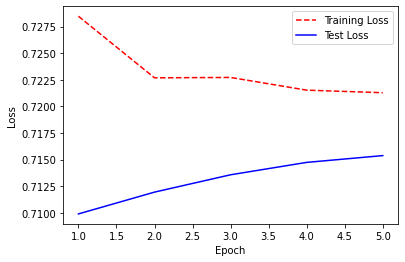

In [39]:
plot_loss(history)

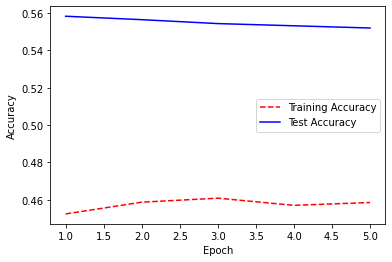

In [38]:
plot_accuracy(history)